# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
%cuda_context_handler gpu_ctx_refined

## Selecting loc

As initial and boundary conditions to the simulation, we use data from the Norkyst800 s-level files:

In [5]:
nk800_url  = ["/sintef/data/NorKyst800/ocean_his.an.20190716.nc"]
# nk800_url  = "C:\\Users\\florianb\\Documents\\havvarsel-data\\ocean_his.an.20190716.nc"

data_args = NetCDFInitialization.removeMetadata(NetCDFInitialization.getInitialConditionsNorKystCases(nk800_url, "lofoten", download_data=False, norkyst_data=False))
data_args.keys()

dict_keys(['nx', 'ny', 'dx', 'dy', 'g', 'r', 'H', 'eta0', 'hu0', 'hv0', 'angle', 'latitude', 'f', 'boundary_conditions_data', 'boundary_conditions', 'wind'])

In [6]:
sim_args = {
    "dt": 0.0,
    "write_netcdf":False,
    "model_time_step": 60
     }

## Simulation

In [7]:
from gpuocean.SWEsimulators import CDKLM16

sim = CDKLM16.CDKLM16(gpu_ctx, **sim_args, **data_args)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


### Refined Simulation

Defining local area

In [8]:
# [[y0,x0],[y1,x1]]
loc = [[100, 100], [200,300]]

scale = 1.2

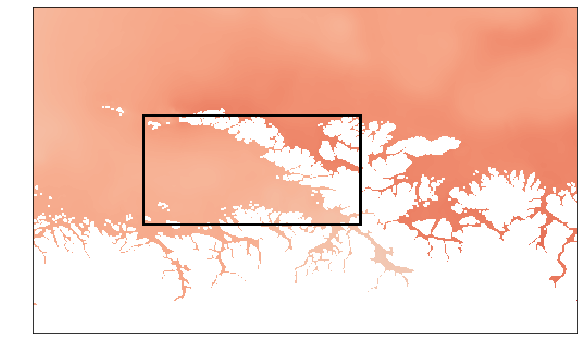

In [9]:
eta, hu, hv = sim.download()

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.imshow(eta, origin="lower", vmin=-1, vmax=1, cmap="coolwarm")

import matplotlib.patches as patches
area = patches.Rectangle((loc[0][0], loc[0][1]), loc[1][1]-loc[0][1], loc[1][0]-loc[0][0], edgecolor='black', facecolor='none', lw=3)
ax.add_patch(area)

Extract local IC

In [10]:
data_args_loc_refined = {}

In [11]:
eta0_loc, hu0_loc, hv0_loc = [x[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]] for x in sim.download()]

In [12]:
ny_loc, nx_loc = np.array(eta0_loc.shape)

data_args_loc_refined["ny"], data_args_loc_refined["nx"] = int(ny_loc * scale), int(nx_loc * scale)

In [13]:
from gpuocean.utils import OceanographicUtilities

In [14]:
# The local area is rescaled 
# Around the local area a ring with ghost cells is padded 
# (values dont matter since will be overwritten with BC in simulator)

In [15]:
eta0_loc_refined = OceanographicUtilities.rescaleMidpoints(eta0_loc, data_args_loc_refined["nx"], data_args_loc_refined["ny"])[2]
eta0_loc_refined_data = np.pad( eta0_loc_refined.data, ((2,2),(2,2)), mode="edge")
eta0_loc_refined_mask = np.pad( eta0_loc_refined.mask, ((2,2),(2,2)), mode="edge")
data_args_loc_refined["eta0"] = np.ma.array(eta0_loc_refined_data, mask=eta0_loc_refined_mask)

hu0_loc_refined = OceanographicUtilities.rescaleMidpoints(hu0_loc, data_args_loc_refined["nx"], data_args_loc_refined["ny"])[2]
hu0_loc_refined_data = np.pad( hu0_loc_refined.data, ((2,2),(2,2)), mode="edge")
hu0_loc_refined_mask = np.pad( hu0_loc_refined.mask, ((2,2),(2,2)), mode="edge")
data_args_loc_refined["hu0"] = np.ma.array(hu0_loc_refined_data, mask=hu0_loc_refined_mask)

hv0_loc_refined = OceanographicUtilities.rescaleMidpoints(hv0_loc, data_args_loc_refined["nx"], data_args_loc_refined["ny"])[2]
hv0_loc_refined_data = np.pad( hv0_loc_refined.data, ((2,2),(2,2)), mode="edge")
hv0_loc_refined_mask = np.pad( hv0_loc_refined.mask, ((2,2),(2,2)), mode="edge")
data_args_loc_refined["hv0"] = np.ma.array(hv0_loc_refined_data, mask=hv0_loc_refined_mask)

print("Use halo mask according to bathymetry")

Use halo mask according to bathymetry


In [16]:
data_args_loc_refined["H"] = np.pad(OceanographicUtilities.rescaleIntersections(sim.downloadBathymetry()[0][loc[0][0]:loc[1][0]+1,loc[0][1]:loc[1][1]+1], data_args_loc_refined["nx"]+1, data_args_loc_refined["ny"]+1)[2], ((2,2),(2,2)), mode="edge")
print("Construct halo mask according to finer bathymetry information!")

Construct halo mask according to finer bathymetry information!


In [17]:
data_args_loc_refined["dx"], data_args_loc_refined["dy"] = sim.dx/scale, sim.dy/scale 

In [18]:
data_args_loc_refined["g"] = sim.g
data_args_loc_refined["r"] = sim.r

Fixed Textures

In [19]:
# Cell centers of the edge cells in the halo
from gpuocean.SWEsimulators import Simulator

tex_x0 = loc[0][1]/(sim.nx+4) - 1.5/(sim.nx+4)/scale
tex_x1 = loc[1][1]/(sim.nx+4) + 1.5/(sim.nx+4)/scale

tex_y0 = loc[0][0]/(sim.ny+4) - 1.5/(sim.ny+4)/scale
tex_y1 = loc[1][0]/(sim.ny+4) + 1.5/(sim.ny+4)/scale

data_args_loc_refined["angle"] = Simulator.Simulator.sample_texture(sim, "angle_tex", data_args_loc_refined["nx"], data_args_loc_refined["ny"], tex_x0, tex_x1, tex_y0, tex_y1)

In [20]:
data_args_loc_refined["f"] = Simulator.Simulator.sample_texture(sim, "coriolis_f_tex", data_args_loc_refined["nx"], data_args_loc_refined["ny"], tex_x0, tex_x1, tex_y0, tex_y1)

Wind

In [21]:
wind_t = sim.wind_stress.t

In [22]:
import pycuda.driver as cuda
from gpuocean.utils import Common

def windstress_t(sim, wind_t_idx, coord, nx, ny, x0, x1, y0, y1):
    ## Set wind as texture
    if coord == "x":
        GPUtexref = sim.kernel.get_texref("windstress_X_current")
    elif coord == "y":
        GPUtexref = sim.kernel.get_texref("windstress_Y_current")

    sim.gpu_stream.synchronize()
    sim.gpu_ctx.synchronize()

    if coord == "x":
        GPUtexref.set_array(cuda.np_to_array(sim.wind_stress.stress_u[wind_t_idx], order="C"))
    elif coord == "y":
        GPUtexref.set_array(cuda.np_to_array(sim.wind_stress.stress_v[wind_t_idx], order="C"))
    GPUtexref.set_filter_mode(cuda.filter_mode.LINEAR) #bilinear interpolation
    GPUtexref.set_address_mode(0, cuda.address_mode.CLAMP) #no indexing outside domain
    GPUtexref.set_address_mode(1, cuda.address_mode.CLAMP)
    GPUtexref.set_flags(cuda.TRSF_NORMALIZED_COORDINATES) #Use [0, 1] indexing

    sim.gpu_ctx.synchronize()

    
    texref = Common.CUDAArray2D(sim.gpu_stream, nx, ny, 2,2, np.zeros((ny+4,nx+4)))
    get_tex = sim.kernel.get_function("sample_texture")
    get_tex.prepare("Piffffii")
    if coord == "x":
        get_tex.prepared_async_call(sim.global_size,sim.local_size,sim.gpu_stream, texref.data.gpudata, np.int32(2),
                                    np.float32(x0), np.float32(x1), np.float32(y0), np.float32(y1), np.int32(nx+4), np.int32(ny+4))
    elif coord == "y":
        get_tex.prepared_async_call(sim.global_size,sim.local_size,sim.gpu_stream, texref.data.gpudata, np.int32(3),
                                    np.float32(x0), np.float32(x1), np.float32(y0), np.float32(y1), np.int32(nx+4), np.int32(ny+4))

    return texref.data.get()
        

In [23]:
stress_u = [windstress_t(sim, t_idx, "x", data_args_loc_refined["nx"], data_args_loc_refined["ny"], tex_x0, tex_x1, tex_y0, tex_y1) for t_idx in range(len(wind_t))]
stress_v = [windstress_t(sim, t_idx, "y", data_args_loc_refined["nx"], data_args_loc_refined["ny"], tex_x0, tex_x1, tex_y0, tex_y1) for t_idx in range(len(wind_t))]

In [24]:
from gpuocean.utils import WindStress

data_args_loc_refined["wind"] = WindStress.WindStress(t=wind_t, stress_u=stress_u, stress_v=stress_v)

In [25]:
data_args_loc_refined["boundary_conditions"] = copy.deepcopy(sim.boundary_conditions)

NOTE: Later on, no relaxation (spongeCells=0) will be needed due to a flux correction term!

Init new refined sim

In [26]:
sim_refined = CDKLM16.CDKLM16(gpu_ctx_refined, **sim_args, **data_args_loc_refined)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


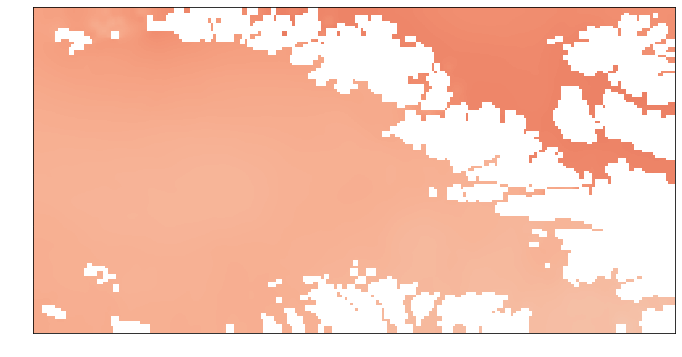

In [27]:
eta, hu, hv = sim_refined.download()

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.imshow(eta, origin="lower", vmin=-1, vmax=1, cmap="coolwarm")